In [47]:

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import loading
import process_aravec
from gensim.models import Word2Vec
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.layers import Input,Embedding, Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dense,Dropout,LSTM,Flatten,GRU,Bidirectional,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns             
from keras import regularizers
from keras.models import Model


In [69]:
max_features = 5000
max_len = 200
training_samples = 8000  # We will be training on 200 samples
validation_samples = 2000  # We will be validating on 10000 samples
# Convolution
kernel_size = 5
filters = 64
pool_size = 2

# LSTM
lstm_output_size = 70
#keras model
epochs = 10
batch_size=50

#data directory
#data_dir = '../data/SplitedPalSent'
#data_dir = '../data/ASTD'
#data_dir = '../data/labr5/clean'
#data_dir = '../data/labr3'
#data_dir = '../data/labr2'
#data_dir = '../data/Shami'
#train_dir = '../data/D6_26/6dialects/splited_train/BEI'
#test_dir = '../data/D6_26/6dialects/splited_dev/BEI'
train_dir = '../data/Dialect6/Multi_data/train/pre_clean'
test_dir = '../data/Dialect6/Multi_data/dev/pre_clean'



In [70]:
import loading
input_train, y_train  = loading.load_train(train_dir,max_len,training_samples,validation_samples,max_features, Validation = False, binary = False )
input_test, y_test = loading.load_test(test_dir,max_len,max_features,binary = False )
print(len(input_train))
print((y_train[10]))
print(input_test[1])




../data/Dialect6/Multi_data/train/pre_clean/train
Found 39818 unique tokens.
Shape of data tensor: (54000, 200)
Shape of label tensor: (54000,)
54000
[0. 0. 1. 0. 0. 0.]
[  48  795 2375    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    

In [71]:
def embedding_matrix(data_dir,max_len,max_features):
    ara_dir = '../data/tweet_cbow_300/'
    word_index = loading.word_index(data_dir,max_len,max_features)
    t_model = Word2Vec.load(os.path.join(ara_dir,'tweets_cbow_300'))

    print('Found %s word vectors.' % len(t_model.wv.index2word))# how many words in aravec this model
    embeddings_index = t_model.wv

    embedding_dim = embeddings_index.vector_size #300
    embedding_matrix = np.zeros((max_features, embedding_dim))

    for word, i in word_index.items():
        word = process_aravec.clean_str(word).replace(" ", "_")
        check = False
        if word in embeddings_index:
            w = word
            check = True
        elif word[1:] in embeddings_index:
            w= word[1:]
            check = True
        elif word[:-2] in embeddings_index:
            w= word[:-2]
            check = True
        if check:
            embedding_vector = embeddings_index[w]
            if i < max_features:
                if embedding_vector is not None:
                    # Words not found in embedding index will be all-zeros.
                    embedding_matrix[i] = embedding_vector
                    #print(len(embedding_vector))
       
        
    return  embedding_matrix  
embedding_matrix = embedding_matrix(train_dir,max_len,max_features)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / max_features)
#for dialetct PAl it only covers 35% of the vocabulary
# for MSA it covers 98%
#ASTD . 90%
#shami 67%

Found 331679 word vectors.
0.987


#building model CNN + LSTM
#tried on ASTD 
model = Sequential()
model.add(Embedding(max_features, 100,weights=[embedding_matrix], trainable=True, input_length=max_len))
model.add(LSTM(70,dropout=0.5, recurrent_dropout=0.5))#,return_sequences=True)))
#model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(30))
#model.add(Dropout(0.5))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())



model = Sequential()
model.add(Embedding(max_features, 100,weights=[embedding_matrix], trainable=True, input_length=max_len))
#model.add(Flatten())
#model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
#model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


In [72]:
model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.
#model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Dense(500,input_dim=max_len, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(200, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(6, kernel_initializer="glorot_uniform", activation="sigmoid"))
model_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 500)               100500    
_________________________________________________________________
dropout_53 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_54 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_55 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 6)                 1206      
Total para

In [ ]:
#MADAR
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=False)))
#model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
from keras import optimizers
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Dense(500,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(6,kernel_initializer="glorot_uniform",activation="sigmoid"))
model_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])
model.summary()

In [ ]:
#LSTM  EXP 16
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


In [ ]:
#CNN_19,2


def create_convnet(max_features, vectore_d):
    input_shape = Input(shape=(max_features, vectore_d))
    conv = []
    for filters in [32,64,128]:
        for k_size in [2,3,4,5,6]:
            tower = Conv1D(filters, k_size, activation='relu')(input_shape)
            tower = GlobalMaxPooling1D()(tower)
            conv.append(tower)
    
    merged = layers.concatenate([tower for tower in conv], axis=1)
   
    
    out = Dense(10,activation='relu')(merged)
    #out = Dropout(0.3)(out)
    #out = Dense(30)(out)
    out = Dense(6, activation='sigmoid')(out)

    model = Model(input_shape, out)
    #print(model.summary())
    from keras.utils.vis_utils import plot_model
    #plot_model(model, to_file=filepath+'.png', show_shapes=True, show_layer_names=True)
    return model


input_shape =(max_features, )
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences= True)))
model.add(Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences= True)))
model.add(create_convnet(max_len, 128))



model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())


#EXP LSTM 9+17
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


#building model CNN + LSTM kagg
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding='valid', activation='relu', strides=1))
#model.add(Flatten())
model.add(LSTM(lstm_output_size, dropout = 0.3, recurrent_dropout=0.3))
model.add(Dense(3,activation='sigmoid'))
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
print(model.summary())   
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='weights/kaggle.png', show_shapes=True, show_layer_names=True)
    

In [73]:
#filepath="weights/weights.best.exp_16.hdf5"

#model.load_weights(filepath)
filepath="weights.best.madar_embediing.hdf5"

#saved_model = filepath
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#callbacks_list = [checkpoint,early_stopping]
history = model.fit(input_train, y_train,
                    epochs=100,
                    batch_size=50,
                    #validation_data=(x_val, y_val),
                    validation_split= 0.2,
                    callbacks=callbacks_list)#[checkpoint])#[early_stopping])


model.save_weights(filepath)   

Train on 43200 samples, validate on 10800 samples
Epoch 1/100
43200/43200 [==============================] - 10s 231us/step - loss: 1.7921 - acc: 0.1761 - val_loss: 1.7883 - val_acc: 0.1888

Epoch 00001: val_loss improved from inf to 1.78834, saving model to weights.best.madar_embediing.hdf5
Epoch 2/100
43200/43200 [==============================] - 7s 161us/step - loss: 1.7880 - acc: 0.1878 - val_loss: 1.7855 - val_acc: 0.1965

Epoch 00002: val_loss improved from 1.78834 to 1.78545, saving model to weights.best.madar_embediing.hdf5
Epoch 3/100
43200/43200 [==============================] - 7s 169us/step - loss: 1.7867 - acc: 0.1912 - val_loss: 1.7845 - val_acc: 0.1918

Epoch 00003: val_loss improved from 1.78545 to 1.78447, saving model to weights.best.madar_embediing.hdf5
Epoch 4/100
43200/43200 [==============================] - 7s 173us/step - loss: 1.7850 - acc: 0.1966 - val_loss: 1.7834 - val_acc: 0.1934

Epoch 00004: val_loss improved from 1.78447 to 1.78341, saving model to wei

43200/43200 [==============================] - 6s 149us/step - loss: 1.7788 - acc: 0.2038 - val_loss: 1.7775 - val_acc: 0.2034

Epoch 00038: val_loss improved from 1.77832 to 1.77753, saving model to weights.best.madar_embediing.hdf5
Epoch 39/100
43200/43200 [==============================] - 9s 198us/step - loss: 1.7782 - acc: 0.2056 - val_loss: 1.7783 - val_acc: 0.2010

Epoch 00039: val_loss did not improve from 1.77753
Epoch 40/100
43200/43200 [==============================] - 6s 144us/step - loss: 1.7781 - acc: 0.2046 - val_loss: 1.7786 - val_acc: 0.2057

Epoch 00040: val_loss did not improve from 1.77753
Epoch 41/100
43200/43200 [==============================] - 8s 175us/step - loss: 1.7786 - acc: 0.2026 - val_loss: 1.7781 - val_acc: 0.2037

Epoch 00041: val_loss did not improve from 1.77753
Epoch 42/100
43200/43200 [==============================] - 12s 288us/step - loss: 1.7783 - acc: 0.2032 - val_loss: 1.7789 - val_acc: 0.2032

Epoch 00042: val_loss did not improve from 1.777

43200/43200 [==============================] - 7s 158us/step - loss: 1.7761 - acc: 0.2071 - val_loss: 1.7760 - val_acc: 0.2080

Epoch 00079: val_loss did not improve from 1.77493
Epoch 80/100
43200/43200 [==============================] - 7s 152us/step - loss: 1.7759 - acc: 0.2060 - val_loss: 1.7756 - val_acc: 0.2089

Epoch 00080: val_loss did not improve from 1.77493
Epoch 81/100
43200/43200 [==============================] - 7s 156us/step - loss: 1.7774 - acc: 0.2051 - val_loss: 1.7761 - val_acc: 0.2059

Epoch 00081: val_loss did not improve from 1.77493
Epoch 82/100
43200/43200 [==============================] - 7s 154us/step - loss: 1.7765 - acc: 0.2088 - val_loss: 1.7764 - val_acc: 0.2093

Epoch 00082: val_loss did not improve from 1.77493
Epoch 83/100
43200/43200 [==============================] - 7s 153us/step - loss: 1.7764 - acc: 0.2076 - val_loss: 1.7763 - val_acc: 0.2056

Epoch 00083: val_loss did not improve from 1.77493
Epoch 84/100
43200/43200 [===========================

# 'Testing And Evalaution'
1- classification report

In [74]:
def plot_show(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

#plot_show(history)
#filepath="weights/weights.best.exp16.hdf5"

model.load_weights(filepath)
#y_test.argmax(axis=1), predicte.argmax(axis=1)
scores= model.evaluate(input_test, y_test,verbose=0)
predicte = model.predict(input_test, verbose = 2, batch_size = batch_size)
print("Accuracy: %.2f%%" % (scores[1]*100))



#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file=filepath+'.png', show_shapes=True, show_layer_names=True)

Accuracy: 22.73%


In [68]:
#test and Evaluation
#model.load_weights(filepath)
#predicted = model.predict_proba(input_test, verbose = 2, batch_size = batch_size)
#for binary
#print(predicte)
#print(metrics.classification_report(y_test, np.round(predicte)))
#for multi-class

print(metrics.classification_report(np.argmax(y_test,axis=1), np.argmax(predicte,axis=1)))


              precision    recall  f1-score   support

           0       0.27      0.49      0.34      1000
           1       0.20      0.45      0.27      1000
           2       0.17      0.01      0.03      1000
           3       0.17      0.02      0.04      1000
           4       0.17      0.02      0.03      1000
           5       0.20      0.32      0.25      1000

   micro avg       0.22      0.22      0.22      6000
   macro avg       0.20      0.22      0.16      6000
weighted avg       0.20      0.22      0.16      6000



0.21133333333333335
Accuracy: 21.13%
[[173 146 128 313 100 140]
 [ 82 281 136 152 163 186]
 [157 100 163 192 167 221]
 [224 156 119 206 155 140]
 [107 186 171 194 182 160]
 [178  91 130 223 115 263]]


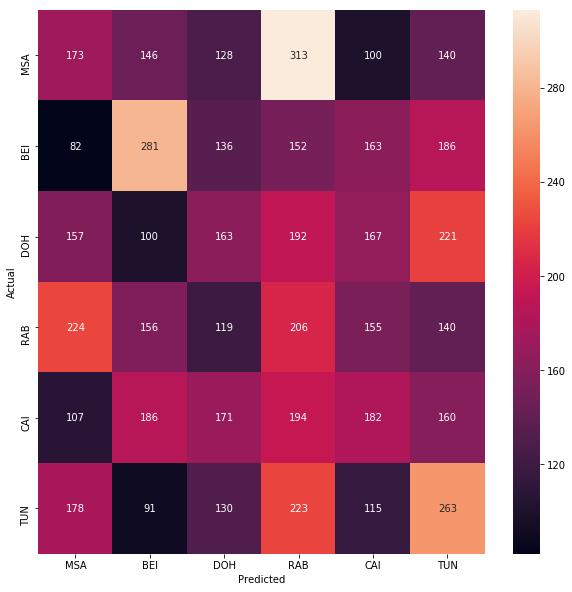

In [46]:
#predicted = np.argmax(predicted, axis=1)
#scores= model.evaluate(input_test, y_test,verbose=0)
#for binary
#print(metrics.accuracy_score(y_test, np.round(predicte)))
#conf_mat = metrics.confusion_matrix(y_test, np.round(predicte))
#for multi
print(metrics.accuracy_score(y_test.argmax(axis=1), predicte.argmax(axis=1)))
conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), predicte.argmax(axis=1))

print("Accuracy: %.2f%%" % (scores[1]*100))
print(conf_mat)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['MSA', 'BEI', 'DOH', 'RAB', 'CAI', 'TUN'], yticklabels=['MSA', 'BEI', 'DOH', 'RAB', 'CAI', 'TUN'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#for x,y,p in zip(input_test,y_test,predicte):
 #   print(x,y,p)


In [ ]:
def create_convnet(max_features, vectore_d):
    input_shape = Input(shape=(max_features, vectore_d))
    tower_1 = Conv1D(64, 3, activation='relu')(input_shape)
    tower_1 = MaxPooling1D(5)(tower_1)
   # tower_1 = Flatten()(tower_1)

    tower_2 = Conv1D(64, 4, activation='relu')(input_shape)
    tower_2 = MaxPooling1D(4)(tower_2)
    #tower_2 = Flatten()(tower_2)

    tower_3 = Conv1D(64, 5, activation='relu')(input_shape)
    tower_3 = MaxPooling1D(3)(tower_3)
    #tower_3 = Flatten()(tower_3)
    
    tower_4 = LSTM(64,dropout=0.5, recurrent_dropout=0.5, return_sequences = True)(input_shape)
    tower_5 = LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences= False)(tower_4)
    #tower_4 = Dense(100, activation = 'relu')(tower_4)
    
    
    
    merged = layers.concatenate([tower_1, tower_2,tower_3], axis=1)
    merged = Flatten()(merged)
    
    final_merged = layers.concatenate([merged,tower_5],axis = 1)
    out = Dense(100,activation='relu')(final_merged)
    #out = Dropout(0.3)(out)
    out = Dense(30)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model(input_shape, out)
    print(model.summary())
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='weights/1CNN.png', show_shapes=True, show_layer_names=True)
    
    return model
create_convnet(max_features, 300)